# 基本的な回路の等価性

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
from math import pi
qc = QuantumCircuit(2)
c = 0
t = 1

量子コンピューターをプログラムするとき、私たちの目標は常に、基本的なパーツから有用な量子回路を構築することです。ただし、必要とする基本的なパーツがすべて揃っていない場合もあります。このセクションでは、基本的なゲートを相互に変換する方法と、ゲートを使用して少し複雑な（しかしそれでもかなり基本的な）ゲートを構築する方法について説明します。

この章で説明する手法の多くは、1995年にバレンコと共著者による論文で最初に提案されました[1]。

## 目次

1. [制御ZをCNOTから作成する](#c-from-cnot)
2. [量子ビットのスワップ](#swapping)
3. [制御回転](#controlled-rotations)
4. [トフォリゲート](#ccx)
5. [HとTによる任意の回転](#arbitrary-rotations)
6. [参考文献](#references)

## 1. 制御ZをCNOTから作成する <a id="c-from-cnot"></a>

制御Zまたは`cz`ゲートは、よく使用されるまた別の2量子ビットゲートです。 CNOTは、その制御量子ビットが $ |1\rangle $の状態にあるときはそのターゲット量子ビットに$X$を適用しますが、同じように、制御$Z$は、同じ場合に$Z$を適用します。 Qiskitでは、制御$Z$を直接呼び出すことができます：

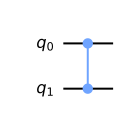

In [2]:
# a controlled-Z
qc.cz(c,t)
qc.draw()

ここで、cとtは制御量子ビットと標的量子ビットです。ただし、IBM Quantumデバイスでは、直接適用できる2量子ビットゲートはCNOTだけです。したがって、変換する方法が必要です。

このプロセスは非常に簡単です。アダマールが $|0\rangle$ および $|1\rangle$ の状態を $|+\rangle$ および $|-\rangle$ の状態に変換することはわかっています。 $|+\rangle$と $|-\rangle$ の状態に対する $Z$ ゲートの影響は、 $|0\rangle$ と $|1\rangle$ の状態に対する $X$ の作用と同じであることもわかっています。このことから、または単純に行列を乗算することから、

$$ H X H = Z,\\ H Z H = X. $$

同じトリックを使用して、CNOTを制御$Z$に変換できます。私たちがしなければならないのは、CNOTの前と後で、アダマールを標的量子ビットに作用させるだけです。これにより、その量子ビットに適用された $X$ が $Z$ に変換されます。

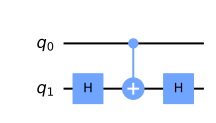

In [3]:
qc = QuantumCircuit(2)
# also a controlled-Z
qc.h(t)
qc.cx(c,t)
qc.h(t)
qc.draw()

より一般的には、単一のCNOTの前後に、正しい回転を配置することにより、ブロッホ球での角度$\pi$の任意の回転の制御バージョンに変換できます。たとえば、制御$Y$は：

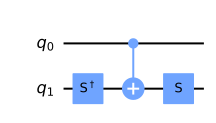

In [4]:
qc = QuantumCircuit(2)
# a controlled-Y
qc.sdg(t)
qc.cx(c,t)
qc.s(t)
qc.draw()

そして、制御$H$は：

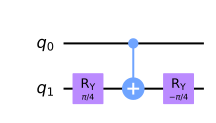

In [5]:
qc = QuantumCircuit(2)
# a controlled-H
qc.ry(pi/4,t)
qc.cx(c,t)
qc.ry(-pi/4,t)
qc.draw()

## 2. 量子ビットのスワップ <a id="swapping"></a>

In [6]:
a = 0
b = 1

量子コンピューター上で情報を移動する必要なときがあります。これを物理的に移動することで実行できるように、実装された量子ビットもありますが、別のオプションとしては、2つの量子ビット間で状態を移動することで情報の移動を実現します。これはSWAPゲートによって行われます。

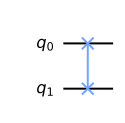

In [7]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.swap(a,b)
qc.draw()

上記のコマンドはこのゲートを直接呼び出しますが、標準のゲートセットを使用してこれを作成する方法を見てみましょう。このためには、いくつかの例を検討する必要があります。

まず、量子ビットaが$|1\rangle$の状態で、量子ビットbが$|0\rangle$の状態である場合を見てみましょう。これには、次のゲートを適用します：

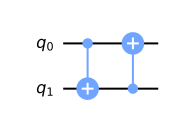

In [8]:
qc = QuantumCircuit(2)
# swap a 1 from a to b
qc.cx(a,b) # copies 1 from a to b
qc.cx(b,a) # uses the 1 on b to rotate the state of a to 0
qc.draw()

これは、量子ビットbを状態$|1\rangle$にし、量子ビットaを状態$|0\rangle$にする効果があります。この場合、少なくともSWAPを実行したことになります。

次に、この状態を元の状態に戻します。ご想像のとおり、上記のプロセスの逆でこれを行うことができます：

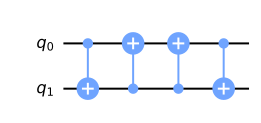

In [9]:
# swap a q from b to a
qc.cx(b,a) # copies 1 from b to a
qc.cx(a,b) # uses the 1 on a to rotate the state of b to 0
qc.draw()

これらの2つのプロセスでは、一方の最初のゲートが他方の初期状態に影響を与えないことに注意してください。たとえば、bの$|1\rangle$をaに交換する場合、最初のゲートは`cx(b,a)`です。代わりに、これが最初にbに$|1\rangle$がなかった状態に適用された場合、効果はありません。

また、これらの2つのプロセスでは、一方の最終ゲートが他方の最終状態に影響を与えないことに注意してください。たとえば、$|1\rangle$をaからbにスワップするときに必要な最後の`cx(b,a)`は、$|1\rangle$がbにない状態には影響しません。

これらの観察結果を元に、一方のゲートからもう一方のゲートに無効なゲートを追加して、2つのプロセスを組み合わせることができます。例えば、

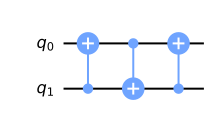

In [10]:
qc = QuantumCircuit(2)
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

これは、aからbに$|1\rangle$を交換するプロセスと考えることができますが、最初は役に立たない `qc.cx(b,a)`があります。また、$|1\rangle$をbからaに交換するプロセスと考えることもできますが、最後に無用な`qc.cx(b,a)`があります。どちらにしても、結果は、双方向でスワップを実行できるプロセスです。

また、状態$|00\rangle$に対して正しく効果を発揮します。これは対称的であるため、状態を入れ替えても影響はありません。制御量子ビットが$|0\rangle$の場合、CNOTゲートは効果がないため、プロセスは何もしません。

状態$|11\rangle$も対称的であるため、スワップによる効果はないに等しいです。この場合、上記のプロセスの最初のCNOTゲートは2番目のゲートに影響を与えず、3番目のゲートは最初のゲートを元に戻します。したがって、全体の効果は確かに無いに等しいです。

このようにして、SWAPゲートを標準ゲートセットである単一量子ビットの回転ゲートとCNOTゲートに分解する方法を見つけました。

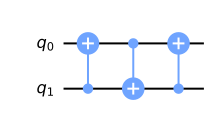

In [11]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(b,a)
qc.cx(a,b)
qc.cx(b,a)
qc.draw()

これは、$|00\rangle$、 $|01\rangle$、 $|10\rangle$、 $|11\rangle$、およびそれらのすべての重ね合わせに対して機能します。したがって、可能なすべての2量子ビット状態をスワップします。

CNOTゲートの順序を変更した場合も、同じ効果が得られます：

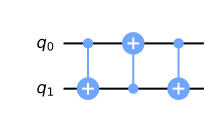

In [12]:
qc = QuantumCircuit(2)
# swaps states of qubits a and b
qc.cx(a,b)
qc.cx(b,a)
qc.cx(a,b)
qc.draw()

これは、SWAPゲートを取得するための同様に有効な方法です。

ここでの導出には、z基底状態に基づいていましたが、状態 $|+\rangle$ と $|-\rangle$でも同じように量子ビットのスワップができ、SWAPゲートを実装する方法は、完全に同じです。

#### 練習問題:

- 量子ビットを状態$|+\rangle$ と $|-\rangle$ でスワップする別の回路を作り、それが上記の回路と等価であることを示してください。

## 3. 制御回転 <a id="controlled-rotations"></a>

制御$\pi$回転を単一のCNOTゲートから構築する方法を見てきました。 次に、任意の制御回転を構築する方法をみていきます。

まず、y軸を中心とした任意の回転を考えてみましょう。 具体的には、次の一連のゲートを考えてみてください。

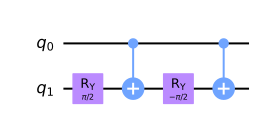

In [13]:
qc = QuantumCircuit(2)
theta = pi # theta can be anything (pi chosen arbitrarily)
qc.ry(theta/2,t)
qc.cx(c,t)
qc.ry(-theta/2,t)
qc.cx(c,t)
qc.draw()

この回路は、制御量子ビットが状態 $|0\rangle$の場合、$R_y(\theta/2)$の後にその逆の $R_y(-\theta/2)$ が続くだけです。この最終的な効果は、無いに等しいです。しかし、制御量子ビットが $|1\rangle$ の場合、`ry(-theta/2)`の前後にXゲートが適用されます。これは、y回転の方向を反転し、2番目の $R_y(\theta/2)$ を作成する効果があります。したがって、この場合の正味の作用は、制御バージョンの回転 $R_y(\theta)$ を作ることと同じになります。

この方法が機能するのは、xとy軸が直行し、そのためにxゲートが回転の方法を反転させるためです。したがって、制御$R_z(\theta)$を作るのも同じように機能します。制御 $R_x(\theta)$ は、CNOTゲートを使って同じように作ることができます。

また、単一量子ビット回転$V$の制御バージョンも作ることができます。そのためには、3つの回転A、B、Cと、次のような位相 $\alpha$ を見つけるだけです。

$$ ABC = I, ~~~e^{i\alpha}AZBZC = V $$

制御Zゲートを使うことで、上の左の式を制御ビットが$|0\rangle$の状態の際に発生させ、右の式を制御ビットが$|1\rangle$の状態のときに発生させます。正しい位相を得るために制御ビット側で$R_z(2\alpha)$回転も使われ、これは、重ね合わせ状態がある場合に重要です。

In [14]:
A = Gate('A', 1, [])
B = Gate('B', 1, [])
C = Gate('C', 1, [])
alpha = 1 # arbitrarily define alpha to allow drawing of circuit

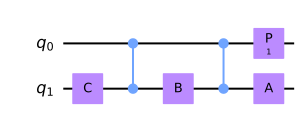

In [15]:
qc = QuantumCircuit(2)
qc.append(C, [t])
qc.cz(c,t)
qc.append(B, [t])
qc.cz(c,t)
qc.append(A, [t])
qc.p(alpha,c)
qc.draw()

![ゲートVの制御バージョン](images/iden1.png)

ここで、`A`、 `B` 、`C`はそれぞれ、$A$ 、$B$ 、$C$を実装するゲートです。

## 4. トフォリゲート <a id="ccx"></a>

トフォリゲートは、2つの制御と1つの標的を持つ３量子ビットゲートです。両方の制御ビットが $|1\rangle$ の状態の時のみ標的ビットにXを適用します。標的ビットの最終状態は、標的ビットの初期状態が $|0\rangle$ または $|1\rangle$ のどちらであったかに応じて、2つの制御ビットのANDまたはNANDのいずれかに等しくなります。トフォリは、制御・制御NOTとも考えることもでき、CCXゲートとも呼ばれます。

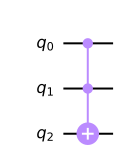

In [16]:
qc = QuantumCircuit(3)
a = 0
b = 1
t = 2
# Toffoli with control qubits a and b and target t
qc.ccx(a,b,t)
qc.draw()

単一量子ビットゲートと2量子ビットゲートからこれを構築する方法を確認するために、まず、より一般的なものを構築する方法を示します：任意の単一量子ビット回転Uについての、任意の制御・制御Uです。そのためには、制御バージョンの $V = \sqrt{U}$ と $V^\dagger$ の定義が必要です。以下のコードでは、未定義のサブルーチン `cv` と `cvdg` の代わりに、それぞれ `cp(theta,c,t)` と `cp(-theta,c,t)` を使っています。制御ビットは量子ビット $a$ と $b$で、ターゲットビットは量子ビット $t$ です。

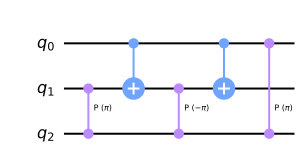

In [17]:
qc = QuantumCircuit(3)
qc.cp(theta,b,t)
qc.cx(a,b)
qc.cp(-theta,b,t)
qc.cx(a,b)
qc.cp(theta,a,t)
qc.draw()

![A doubly controlled version of a gate V](https://github.com/Qiskit/textbook/blob/main/translations/ja/ch-gates/images/iden2.png?raw=true)

2つの制御ビットの各値を見ていくことで、両方の制御ビットが1の場合にのみ、Uゲートがターゲットビットに適用されることを確認できます。すでに説明したアイデアを使って、二重制御されたUゲートのある回路を使って、各制御Vゲートを実装することができるでしょう。これから、トフォリゲートを実装するために必要なCNOTゲートの数は最小で6であることがわかります[2]。

![A Toffoli](https://github.com/Qiskit/textbook/blob/main/translations/ja/ch-gates/images/iden3.png?raw=true)

これは、3量子ビット(q0、q1、q2)のトフォリゲートです。この回路例では、q0はq2に接続されていますが、q0はq1に接続されていません。

トフォリは、量子コンピューティングでANDゲートを実装するための唯一の方法ではありません。同じ効果があり、相対位相を持つ他のゲートも定義することができます。これらの場合、より少ないCNOTでゲートを実装できます。

例えば、制御アダマールゲートと制御$Z$ゲートを使うとします。これらのゲートは、両方とも1つのCNOTで実装できます。これらのゲートから次の回路を作成できます：

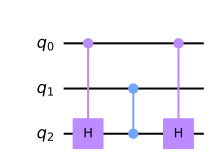

In [18]:
qc = QuantumCircuit(3)
qc.ch(a,t)
qc.cz(b,t)
qc.ch(a,t)
qc.draw()

2つの制御が状態$|00\rangle$の場合、これはターゲットに対して何もしません。 $|11\rangle$の場合、ターゲットは前後に $H$ がある $Z$ ゲートの影響を受けます。正味の効果はターゲットに対する$X$です。状態$|01\rangle$および$|10\rangle$の場合、ターゲットは2つのアダマール(互いに打ち消し合う)または$Z$(相対位相のみを誘導する)のいずれかの影響を受けます。したがって、これはANDの効果も再現します。これは、ターゲットの値が制御の$|11\rangle$状態でのみ変更されるためですが、このことはたった3つのCNOTゲートに相当するもので再現されます。

## 5. HとTによる任意の回転 <a id="arbitrary-rotations"></a>

現在のデバイスの量子ビットはノイズの影響を受けやすく、基本的に誤ったゲートで構成されています。温度や浮遊磁場、隣接する量子ビットの活動などの単純なことが、私たちが意図していなかったことを引き起こす可能性があります。

量子コンピューターの大規模なアプリケーションでは、このノイズから量子ビットを保護するように量子ビットをエンコードする必要があります。これは、ゲートを間違って実行することを難しくするか、またはわずかに間違った方法で実装することによって行われます。

単一量子ビットの回転$R_x(\theta)$、 $R_y(\theta)$ 、 $R_z(\theta)$ は残念ですが、角度 $\theta$ を完璧な精度で実装するのは不可能です。これは、あなたが、角度 $\theta + 0.0000001$ のようなものを間違って実装することがないのと同じです。達成できる精度には常に限界があり、大きな回路ではエラーの積み重ねがあることを考慮すると、その精度は許容範囲を常に超えています。したがって、これらの回転をフォールトトレラントな量子コンピューターに直接実装することはできませんが、代わりに、より工夫した方法で回転を構築する必要があります。

フォールトトレラントのスキームでは、通常2つのみのゲート、$H$ と $T$ を複数適用することによってこれらの回転を実行します。

Tゲートは、Qiskitでは`.t()`として表現されます：

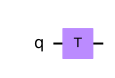

In [19]:
qc = QuantumCircuit(1)
qc.t(0) # T gate on qubit 0
qc.draw()

これは、z軸を中心とした$\theta = \pi/4$の回転であるため、数学的には $R_z(\pi/4) = e^{i\pi/8~Z}$として表されます。

以下では、$H$ゲートと$T$ゲートが事実上完全であると想定しています。これは、エラー訂正とフォールトトレランスに適した方法で設計できます。

アダマールと前の章で説明した方法を使用して、Tゲートを使用してx軸の周りに同様の回転を作成することができます。

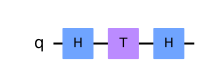

In [20]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

それでは、2つを組み合わせてみましょう。ゲートを$R_z(\pi/4)~R_x(\pi/4)$にしましょう。

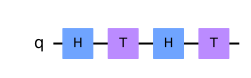

In [21]:
qc = QuantumCircuit(1)
qc.h(0)
qc.t(0)
qc.h(0)
qc.t(0)
qc.draw()

これは単一量子ビットのゲートであるため、ブロッホ球の周りの回転と考えることができます。これは、ある軸を中心にある角度で回転することを意味します。ここでは軸についてあまり考える必要はありませんが、単純にx、y、zになるわけではありません。さらに重要なのは角度です。

この回転の角度の重要な特性は、回転角が$\pi$の無理数の倍数であるということです。数学を駆使することで証明することはできますが、ゲートを適用することによって実際に無理数である様子を見ることができます。 $2\pi$より大きい回転を適用するたびに、回転角に対して暗黙的に$2\pi$の剰余を計算していることに注意してください。したがって、上記の組み合わせた回転を$n$回繰り返すと、同じ軸を中心に異なる角度で回転します。厳密な証明のヒントとして、「無理数は何として書けないか」を思い出してください。

これを利用すればいいのです。各角度は$0$から$2\pi$の間のどこかになります。この間隔を幅$2\pi/n$の$n$個のスライスに分割してみましょう。繰り返しごとに、結果の角度はこれらのスライスのいずれかに入ります。最初の$n+1$の繰り返しの角度を見ると、鳩の巣原理により、少なくとも1つのスライスにこれらの角度が2つ含まれていることが分かるはずです。最初に必要な繰り返し回数を$n_1$、2回目の繰り返し数を$n_2$とします。

これにより、$n_2-n_1$ 回の繰り返しの際の角度について何かを証明できます。これは実質的に $n_2$ 回の繰り返しの後に $n_1$ 回の逆向きの繰り返しをするのと同じです。これらの角度は等しくない（無理数のため）だけでなく、 $2\pi/n$ 以下の差（同じスライスに対応するため）であるため、 $n_2-n_1$ 回の繰り返しの角度は、

$$ \theta_{n_2-n_1} \neq 0, ~~~~-\frac{2\pi}{n} \leq \theta_{n_2-n_1} \leq \frac{2\pi}{n} . $$

したがって、小さな角度で回転させることができます。 これを使用して、このゲートを繰り返す回数を増やすだけで、好きなだけ小さい角度で回転できます。

小さな角度の回転を多用することで、好きな角度で回転させることもできます。 これは常に正確であるとは限りませんが、$2\pi/n$ の差を除いて正確であることが保証されています。これは、好きなだけ小さくすることができます。 これで、回転の不正確さを管理できるようになりました。

これまでのところ、私たちはこれらの任意の回転を1つの軸を中心に行う力しか持っていません。 2番目の軸については、$R_z(\pi/4)$ と $R_x(\pi/4)$ の回転を逆の順序で行うだけです。

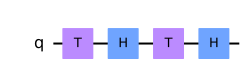

In [22]:
qc = QuantumCircuit(1)
qc.t(0)
qc.h(0)
qc.t(0)
qc.h(0)
qc.draw()

この回転に対応する軸は、前に検討したゲートの軸と同じではありません。したがって、2つの軸の周りに任意の回転があり、これを使用してブロッホ球の周りに任意の回転を生成できます。かなりの$T$ゲートが必要ですが、なんでも実行できるようになりました。

$ T $ゲートが量子計算でよくみられるのは、この種のアプリケーションのためです。実際、フォールトトレラントな量子コンピューターのアルゴリズムの複雑さは、必要な$T$ゲートの数という観点が引き合いに出されることがよくあります。これは、可能な限り少ない$T$ゲートで物事を達成するための探求を駆り立てます。上記の説明は、$T$ゲートをこのように使用できることを証明することを目的としたものであり、私たちが知っている最も効率的な方法を表すものではないことに注意してください。

## 6. 参考文献 <a id="references"></a>

[1] [Barenco, *et al.* 1995](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457?cm_mc_uid=43781767191014577577895&cm_mc_sid_50200000=1460741020)

[2] [Shende and Markov, 2009](http://dl.acm.org/citation.cfm?id=2011799)

In [23]:
import qiskit.tools.jupyter
%qiskit_version_table

/home/divs/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.1
qiskit-aer,0.8.2
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.16.0
qiskit-aqua,0.9.4
qiskit,0.29.0
qiskit-nature,0.1.5
qiskit-finance,0.2.0
qiskit-optimization,0.2.1
qiskit-machine-learning,0.2.0
